In [1]:
! pip install transformers
! pip install torch

### importing libraries 

In [2]:
import torch
import numpy as np
import pandas as pd
from transformers import T5Tokenizer, T5ForConditionalGeneration
import json
import random
from sklearn.model_selection import train_test_split
from itertools import zip_longest

### defining general variables

In [3]:
#defining global valriables throughout the whole notebook
EPOCH = 32
BATCH_SIZE = 64
MAX_INPUT_LENGTH = 65
MAX_LABEL_LENGTH = 8
MODEL_LINK = "google/flan-t5-small"
FOLD_NUMBER = 0
SEED = 0
srl_data_link = '/kaggle/input/srl-w-cluster-number103k/Clustered Dataset.csv'

In [4]:
def set_seed():
    random.seed(SEED)
    np.random.seed(SEED)
    torch.manual_seed(SEED)
    torch.cuda.manual_seed(SEED)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

In [5]:
set_seed()
tokenizer = T5Tokenizer.from_pretrained(MODEL_LINK, legacy=False)
model = T5ForConditionalGeneration.from_pretrained(MODEL_LINK).to('cuda')

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.40k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/308M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

### functions created for reading(get_data) and organize the files (organize_data)

In [6]:
# a funciton to read data off of a database link is here to help getting and organizing data into dataframes
def get_data(address):
    lines = []
    with open(address) as file:
        for line in file:
            x = json.loads(line)
            lines.append(x)
    sentences, orl, sep_sentences = [], [], []
    for i in range(len(lines)):
        sep_sentences.append(lines[i]['sentences'])
        sentences.append(' '.join(lines[i]['sentences']))
        orl.append(lines[i]['orl'])
    dataframe = pd.DataFrame({'sentence': sentences, 'orl': orl, 'sep_sent': sep_sentences})
    return dataframe

# this function is to make a list of the said attribute for later iterations
def list_of(attributes, requested_atr):
    requested_list = []
    for sublist in attributes:
        if sublist[-1] == requested_atr:
            requested_list.append(sublist)
    return requested_list

# this function was made to find target(s)/agent(s) of a dse according to list of attributes
def organize_data(dataframe):
    
    target_column, agent_column, sentence_column, dse_column = [], [], [], []
    
    for i in range(len(dataframe)):
        
        attributes = dataframe['orl'][i]
        sentence   = dataframe['sep_sent'][i]
        target_list= list_of(attributes, 'TARGET')
        agent_list = list_of(attributes, 'AGENT')
        AGENT, DSE, TARGET = '', '', ''
        
        
        for sublist in attributes:
            if sublist[-1] == 'DSE':
                dse_start = int(sublist[0])
                dse_end = int(sublist[1] + 1)
                DSE += ' '.join(sentence[dse_start:dse_end]) + '|'
                
                
                # looking for the targets and agents of this dse that we have found
                for sub_sublist in target_list:
                    if sub_sublist[0] == dse_start and int(sub_sublist[1] + 1) == dse_end:
                        target_start = int(sub_sublist[2])
                        target_end = int(sub_sublist[3] + 1)
                        TARGET += ' '.join(sentence[target_start:target_end]) + ' |'
                if not TARGET:
                    TARGET += ' |'
                
                for sub_sublist in agent_list:
                    if sub_sublist[0] == dse_start and int(sub_sublist[1] + 1) == dse_end:
                        agent_start = int(sub_sublist[2])
                        agent_end = int(sub_sublist[3] + 1)
                        AGENT += ' '.join(sentence[agent_start:agent_end]) + '|'
                if not AGENT:
                    AGENT += ' |'
                # for every iteration of loop over attributes, if a dse is found, then we need to transfer it to new line of a dataframe
                # for each one of the dse(s) i have to add them into a new array so then they can create the correct dataframe
                target_column.append(TARGET)
                agent_column.append(AGENT)
                dse_column.append(DSE)
                sentence_column.append(dataframe['sentence'][i])

    # end of iteration on all sentences
    output_df = pd.DataFrame({'sentence':sentence_column, 'dse':dse_column, 'target':target_column, 'agent':agent_column})
    return output_df

### a function to call for different links of folders with exact process to extract and organize data

In [7]:
def get_files_of_folder(folder_number):
    folder_number = int()
    folder = f"/kaggle/input/ds-json-format/json_format_dataset/{folder_number}"
    dev_df = get_data(f"{folder}/aaai19srl.dev{folder_number}.conll.json")
    df = get_data(f"{folder}/aaai19srl.train{folder_number}.conll.json")
    test_df = get_data(f"{folder}/aaai19srl.test{folder_number}.conll.json")
    return df, dev_df, test_df
df = get_files_of_folder(FOLD_NUMBER)[0]
dev_df = get_files_of_folder(FOLD_NUMBER)[1]
test_df = get_files_of_folder(FOLD_NUMBER)[2]

### getting training/validation/test data into data frames and dividing each of {agent, target, dse} elements

In [8]:
# df = get_data("/kaggle/input/ds-json-format/json_format_dataset/0/aaai19srl.train0.conll.json")

df = organize_data(df)
df

,sentence,dse,target,agent
0,The Kimberley Provincial Hospital said it woul...,would probably know|,whether one of its patients had Congo Fever |,The Kimberley Provincial Hospital|
1,Saeed said indications were that those tests w...,said|,those tests |,Saeed|
2,He said it was his opinion that the patient --...,his opinion|,the patient -- a woman |,He|
3,The woman was admitted to the hospital on Satu...,complaining|,severe joint pains |,The woman|
4,`` Since our technical equipment is far from p...,said|,our technical equipment |we |,Nazarov|
...,...,...,...,...
3530,Benjamin Franklin Federal Savings & Loan Assoc...,plans|,|,it|
3531,thrift said the restructuring should help it m...,said|,the restructuring |,|
3532,Details of the restructuring wo n't be made fi...,approve|,|,regulators|
3533,"Jay Stevens , an analyst with Dean Witter Reyn...",expected|,|,he|


In [9]:
# dev_df = get_data("/kaggle/input/ds-json-format/json_format_dataset/0/aaai19srl.dev0.conll.json")

dev_df = organize_data(dev_df)
dev_df

,sentence,dse,target,agent
0,The owner though that the animal was suffering...,though|,the animal |,The owner|
1,"The owner put down the animal , although the v...",had forbidden|,him to do so |,the vet|
2,"GATUNA , Rwanda , July 6 -LRB- AFP -RRB- - Pre...",soured relations between|,their neighbouring countries |,|
3,"The formerly close allies fell out in 1999 , t...",fell out|,each |,The formerly close allies|
4,"The formerly close allies fell out in 1999 , t...",fell out|mounting rivalry|,each |,The formerly close allies|The formerly close a...
...,...,...,...,...
1504,He said the independent power segment could gr...,said|expect|,the independent power segment |to supply a sig...,He|We|
1505,Westinghouse also expects its international sa...,expects|,|,Westinghouse|
1506,Analysts had expected Consolidated to post a s...,expected|,Consolidated to post a slim profit |,Analysts|
1507,"They have to continue to tighten their belts ,...",said|,They |,"Craig Kloner , an analyst at Goldman , Sachs &..."


In [10]:
# test_df = get_data("/kaggle/input/ds-json-format/json_format_dataset/0/aaai19srl.test0.conll.json")

test_df = organize_data(test_df)
test_df

,sentence,dse,target,agent
0,Private organizations are also being encourage...,are also being encouraged|,help fight sandstorms |,|
1,"It is believed that sand from northern areas ,...",is believed|,"sand from northern areas , especially the Inne...",|
2,Russia favors creation of `` international ins...,favors|,creation of `` international instruments '' to...,Russia|
3,"Moscow , 16 July : The Russian Foreign Ministr...",has called for|,taking into account Russia 's specific interes...,The Russian Foreign Ministry|
4,A Foreign Ministry statement in connection wit...,reads|,taking into account Russia 's interests |,A Foreign Ministry statement|
...,...,...,...,...
888,We will have a reasonably flat year this year ...,says|,reasonably flat year |,Mr. Schwarz|
889,Mr. Schwarz also said costs associated with U....,said|,costs associated with U.S. Trust 's planned mo...,Mr. Schwarz|
890,"Esselte AB , the Stockholm office supplies com...",proposed|,to acquire the 22 % it does n't own of its U.S...,"Esselte AB , the Stockholm office supplies com..."
891,A committee of outside directors for the Garde...,asked|,|,the parent|


### Getting evaluation data into df and dividing each of {agent, target, dse} elements

In [11]:
# function which will write prompt for the model according to the sentence and the items in it
def create_prompt(input_df):
    target_prompt, agent_prompt, target, agent, sentence, dse = [], [], [], [], [], []
    for i in range(len(input_df)):
        target_prompt.append(f"sentence => {input_df['sentence'][i]} <sep> DSE => {input_df['dse'][i]} <sep> TARGET => ")
        agent_prompt.append(f"sentence => {input_df['sentence'][i]} <sep> DSE => {input_df['dse'][i]} <sep> AGENT => ")
        target.append(input_df['target'][i])
        agent.append(input_df['agent'][i])
        sentence.append(input_df['sentence'][i])
        dse.append(input_df['dse'][i])
    output_df = pd.DataFrame({'sentence':sentence, 'dse':dse, 'target_prompt':target_prompt, 'target':target, 'agent_prompt':agent_prompt, 'agent':agent})
    return output_df

### Change the sentence and dse into a prompt according to information in that row 
#### change will be applied on all three data frames {train, test, validation}

In [12]:
dev_df = create_prompt(dev_df).reset_index(drop=True)
train_df = create_prompt(df).reset_index(drop=True)
test_df = create_prompt(test_df).reset_index(drop=True)

In [13]:
from torch.utils.data import DataLoader, Dataset
# Define a custom dataset
class CustomDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length4text, max_length4label):
        self.data = dataframe
        self.tokenizer = tokenizer
        self.max_length4text = max_length4text
        self.max_length4label = max_length4label

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        agent_prompt = self.data['agent_prompt'][idx]
        target_prompt = self.data['target_prompt'][idx]
        agent = self.data['agent'][idx]
        target = self.data['target'][idx]
        # tokenizing agent prompt
        agent_prompt_encoding = self.tokenizer(agent_prompt, truncation=True, padding='max_length', max_length=self.max_length4text, return_tensors='pt').to("cuda")
        # tokenizing target prompt
        target_prompt_encoding = self.tokenizer(target_prompt, truncation=True, padding='max_length', max_length=self.max_length4text, return_tensors='pt').to("cuda")
        # tokenizing agent
        agent_encoding = self.tokenizer(agent, truncation=True, padding='max_length', max_length=self.max_length4label, return_tensors='pt').to("cuda")
        # tokenizing target
        target_encoding = self.tokenizer(target, truncation=True, padding='max_length', max_length=self.max_length4label, return_tensors='pt').to("cuda")
        return {
            # agent prompt
            'agent_input_id': agent_prompt_encoding['input_ids'].squeeze(),
            'agent_attention_mask': agent_prompt_encoding['attention_mask'].squeeze(),
            # target prompt
            'target_input_id': target_prompt_encoding['input_ids'].squeeze(),
            'target_attention_mask': target_prompt_encoding['attention_mask'].squeeze(),
            #agent
            'agent_id': agent_encoding['input_ids'].squeeze(),
            'agent_mask': agent_encoding['attention_mask'].squeeze(),
            #target
            'target_id': target_encoding['input_ids'].squeeze(),
            'target_mask': target_encoding['attention_mask'].squeeze()
        }

In [14]:
# Define the loss function and optimizer
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [15]:
def f1_calculator(split_pred_list, split_actual_list):
    matched, percision, recall, f1 = 0, 0, 0, 0
    predicted_len, actual_len      = 0, 0
    
    for actual_sublist, prediction_sublist in zip(split_pred_list, split_actual_list):
        predicted_len += len(prediction_sublist)
        for i in actual_sublist:
            actual_len += 1
            if i in prediction_sublist:
                matched += 1
    
    print(f"matched: {matched}, predicted_len: {predicted_len}, actual_len: {actual_len}")
    try:
        precision = matched / predicted_len
        recall = matched / actual_len
        f1 = 2 * (precision * recall) / (precision + recall)
    except ZeroDivisionError:
        f1 = 0

    return f1

In [16]:
def clear_data(text_list):
    list_of_items_in_text = []
    for single_list in text_list:
        for i in single_list.split('|'):
            i = i.lower().replace(" ", "")  # Convert to lowercase and remove extra whitespace
            if i:  # Check if `i` is not empty after stripping
                list_of_items_in_text.append(i)
    return list_of_items_in_text

In [17]:
a = ['clear as day| iMportant| noted and clear| |']
print(clear_data(a))

['clearasday', 'important', 'notedandclear']


In [18]:
def evaluate_model(model, dataloader, prompt_type):
    if prompt_type == 'target':
        id_type = 'target_input_id'
        attention_type = 'target_attention_mask'
        output_type = 'target_id'
    elif prompt_type == 'agent':
        id_type = 'agent_input_id'
        attention_type = 'agent_attention_mask'
        output_type = 'agent_id'
    
    model.eval()  # Set the model to evaluation mode
    with torch.no_grad():
        actual_list, prediction_list = [], []
        for batch_idx, batch in enumerate(dataloader):
            
            # Forward pass
            ids = batch[id_type]
            mask = batch[attention_type]
            output_id = batch[output_type]
            
            actuals = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in output_id]
            
            generated_output = model.generate(
              input_ids = ids,
              attention_mask = mask, 
              max_length=64, 
              )
            preds = [tokenizer.decode(g, skip_special_tokens=True, clean_up_tokenization_spaces=True) for g in generated_output]
            
            actual_list.append(clear_data(actuals))
            prediction_list.append(clear_data(preds))
            
    return f1_calculator(prediction_list, actual_list)

In [19]:
f1_scores_target, f1_scores_agent = [], []
#           data_loader:train,v_data_loader:validation
def train_data(data_loader, v_data_loader):
    data_list = []
    model.train()
    for epoch in range(EPOCH):
        losses = []
        for batch in data_loader:

            agent_input = batch['agent_input_id']
            agent_attention_mask = batch['agent_attention_mask']

            target_input = batch['target_input_id']
            target_attention_mask = batch['target_attention_mask']

            agent_id = batch['agent_id']
            agent_mask = batch['agent_mask']

            target_id = batch['target_id']
            target_mask = batch['target_mask']

            optimizer.zero_grad()

            agent_output = model(agent_input, attention_mask=agent_attention_mask, labels=agent_id)
            target_output = model(target_input, attention_mask=target_attention_mask, labels=target_id)
            
            # created just for examination
            # has no contribution to accuracy of model output
            # temprorarly_pd = pd.DataFrame([{
            #     'actual_agent': [tokenizer.decode(a) for a in agent_input],
            #     'agent_model_output': agent_output,
            #     'actual_target': [tokenizer.decode(c) for c in target_input],
            #     'target_model_output': target_output
            # }])
            # 
            # 
            
            agent_loss = agent_output.loss
            target_loss = target_output.loss
            losses.append(agent_loss.item())
            losses.append(target_loss.item())

            agent_loss.backward()
            target_loss.backward()
            optimizer.step()
            

        f1_4_target = evaluate_model(model, v_data_loader, 'target')
        f1_4_agent = evaluate_model(model, v_data_loader, 'agent')
        
        f1_scores_target.append(f1_4_target)
        f1_scores_agent.append(f1_4_agent)
        
        # report the results of training function.
        print(f'loss: {np.mean(losses)}, f1 for target:{f1_4_target}, f1 for agent:{f1_4_agent} \n end of epoch{epoch}. \n')

# By this box, mpqa/orl data is ready to be combined with different forms of clustering being applied on the rest of the data

### .
### .
### .
### .
## chosing randomly out of SRL_without_anchors for calculating the results
### .
### .
### .
### .

In [20]:
srl = pd.read_csv(srl_data_link)
agents, targets, verbs, sentences, cluster_number = [], [], [], [], []
for i in range(len(srl)):
    
    #single line of data is selected from df
    line = srl.iloc[i]
    
    #check for both ARGS, 
    #if both are empty skips that line.
    #if either one of the args is filled-
    #-process continues.
    if line['ARG0'] or line['ARG1']:
        if line['ARG0']:
            agents.append(line['ARG0'])
        else:
            agents.append("")
        if line['ARG1']:
            targets.append(line['ARG1'])
        else:
            targets.append("")
        sentences.append(line['SENTENCE'])
        verbs.append(line['PREDICATES'])
        cluster_number.append(line['Cluster_Number'])

srl_df = pd.DataFrame({'sentences': sentences, 'verbs': verbs, 'agents': agents, 'targets': targets, 'cluster_no':cluster_number}, dtype='object').fillna('')
srl_df

/tmp/ipykernel_23/703013003.py:25: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  srl_df = pd.DataFrame({'sentences': sentences, 'verbs': verbs, 'agents': agents, 'targets': targets, 'cluster_no':cluster_number}, dtype='object').fillna('')


,sentences,verbs,agents,targets,cluster_no
0,"Pierre Vinken , 61 years old , will join the b...",join,"Pierre Vinken , 61 years old ,",the board,6
1,"Mr. Vinken is chairman of Elsevier N.V. , the ...",is,,Mr. Vinken,6
2,"Mr. Vinken is chairman of Elsevier N.V. , the ...",publishing,group,,6
3,"Rudolph Agnew , 55 years old and former chairm...",named,,"Rudolph Agnew , 55 years old and former chairm...",6
4,A form of asbestos once used to make Kent ciga...,used,,A form of asbestos,4
...,...,...,...,...,...
97164,`` We emphasize discipline because we know tha...,is,,another early Umkhonto leader who,0
97165,`` We want to see Nelson Mandela and all our c...,want,We,to see Nelson Mandela and all our comrades out...,2
97166,`` We want to see Nelson Mandela and all our c...,see,We,Nelson Mandela and all our comrades out of prison,2
97167,`` We want to see Nelson Mandela and all our c...,disciplined,,we,2


In [21]:
agent_prompts, agents, target_prompts, targets, cluster_no = [], [], [], [], []
for i in range(len(srl_df)):
    line = srl_df.iloc[i]
    agent_prompts.append(f"sentence => {line['sentences']} <sep> DSE => {line['verbs']} <sep> AGENT => ")
    agents.append(line['agents'])
    target_prompts.append(f"sentence => {line['sentences']} <sep> DSE => {line['verbs']} <sep> TARGET => ")
    targets.append(line['targets'])
    cluster_no.append(line['cluster_no'])
    # (f"sentence is: \{{input_df['sentence'][i]}} this is DSE: {input_df['dse'][i]}. find target for DSE in the sentence?")
srl_df = []
srl_df = pd.DataFrame({'agent_prompt': agent_prompts, 'agent': agents, 'target_prompt': target_prompts, 'target': targets, 'cluster_no':cluster_no})
srl_df

,agent_prompt,agent,target_prompt,target,cluster_no
0,"sentence => Pierre Vinken , 61 years old , wil...","Pierre Vinken , 61 years old ,","sentence => Pierre Vinken , 61 years old , wil...",the board,6
1,sentence => Mr. Vinken is chairman of Elsevier...,,sentence => Mr. Vinken is chairman of Elsevier...,Mr. Vinken,6
2,sentence => Mr. Vinken is chairman of Elsevier...,group,sentence => Mr. Vinken is chairman of Elsevier...,,6
3,"sentence => Rudolph Agnew , 55 years old and f...",,"sentence => Rudolph Agnew , 55 years old and f...","Rudolph Agnew , 55 years old and former chairm...",6
4,sentence => A form of asbestos once used to ma...,,sentence => A form of asbestos once used to ma...,A form of asbestos,4
...,...,...,...,...,...
97164,sentence => `` We emphasize discipline because...,,sentence => `` We emphasize discipline because...,another early Umkhonto leader who,0
97165,sentence => `` We want to see Nelson Mandela a...,We,sentence => `` We want to see Nelson Mandela a...,to see Nelson Mandela and all our comrades out...,2
97166,sentence => `` We want to see Nelson Mandela a...,We,sentence => `` We want to see Nelson Mandela a...,Nelson Mandela and all our comrades out of prison,2
97167,sentence => `` We want to see Nelson Mandela a...,,sentence => `` We want to see Nelson Mandela a...,we,2


#### randomly selecting number of this dataframe to be fed into the model

In [22]:
def random_sample_df(df, num_rows, SEED=None):
    # Check if num_rows is larger than the available number of rows in the DataFrame
    if num_rows > len(df):
        raise ValueError(f"Requested {num_rows} rows, but the DataFrame only contains {len(df)} rows.")
    
    # Sample the DataFrame and return the result
    sampled_df = df.sample(n=num_rows, random_state=SEED)
    return sampled_df

def random_sample_from_all_clusters(df, num_rows_per_cluster, cluster_column, SEED=None):
    # Check if the cluster_column exists in the DataFrame
    if cluster_column not in df.columns:
        raise ValueError(f"Column '{cluster_column}' not found in DataFrame.")

    # Create an empty list to hold the sampled data for each cluster
    sampled_dfs = []

    # Group the DataFrame by the cluster column
    grouped = df.groupby(cluster_column)

    # Iterate over each cluster and sample rows
    for cluster, group in grouped:
        # Check if the group has enough rows to sample
        if len(group) < num_rows_per_cluster:
            raise ValueError(f"Cluster '{cluster}' has only {len(group)} rows, but {num_rows_per_cluster} were requested.")
        
        # Sample the rows from the current cluster
        sampled_group = group.sample(n=num_rows_per_cluster, random_state=SEED)
        sampled_dfs.append(sampled_group)

    # Concatenate the sampled DataFrames for each cluster
    sampled_df = pd.concat(sampled_dfs).reset_index(drop=True)

    return sampled_df


srl_train_nk = random_sample_from_all_clusters(srl_df, 400, 'cluster_no', SEED)
srl_train_nk

,agent_prompt,agent,target_prompt,target,cluster_no
0,sentence => Some countries also have been pres...,Some countries,sentence => Some countries also have been pres...,,0
1,"sentence => Ms. Malcolm , for example , wrote ...",Mr. Masson,"sentence => Ms. Malcolm , for example , wrote ...",himself,0
2,"sentence => Gary Hoffman , a Washington lawyer...",,"sentence => Gary Hoffman , a Washington lawyer...",the threat of U.S. retaliation,0
3,sentence => `` A lot of investor confidence co...,,sentence => `` A lot of investor confidence co...,A lot of investor confidence,0
4,"sentence => One analyst , Peter Cardillo of Jo...",,"sentence => One analyst , Peter Cardillo of Jo...",prices,0
...,...,...,...,...,...
3995,sentence => At St. Mary 's Church in Ilminster...,,sentence => At St. Mary 's Church in Ilminster...,the bells,9
3996,sentence => But the worst possibility would be...,,sentence => But the worst possibility would be...,the worst possibility,9
3997,sentence => `` I think it would be irresponsib...,by Japanese banks or any other international i...,sentence => `` I think it would be irresponsib...,I,9
3998,sentence => The adjuster had n't completed all...,The adjuster,sentence => The adjuster had n't completed all...,We 're talking policy limits,9


In [23]:
def combine_and_shuffle(df1, df2, SEED=None):
    """
    Combines two DataFrames with the same columns and shuffles the rows.

    Args:
        df1 (pd.DataFrame): The first DataFrame.
        df2 (pd.DataFrame): The second DataFrame.
        seed (int, optional): Random seed for reproducibility.

    Returns:
        pd.DataFrame: A new DataFrame with rows from both DataFrames shuffled.
    """
    # Combine the two DataFrames using pd.concat
    combined_df = pd.concat([df1, df2], ignore_index=True)
    
    # Shuffle the combined DataFrame
    shuffled_df = combined_df.sample(frac=1, random_state=SEED).reset_index(drop=True)
    
    return shuffled_df
orl_srl = combine_and_shuffle(train_df, srl_train_nk, SEED)
orl_srl.drop(columns=['cluster_no', 'sentence', 'dse'], inplace=True)
orl_srl

,target_prompt,target,agent_prompt,agent
0,sentence => It is time for the former officer ...,|the Cuban model no longer works even for Hav...,sentence => It is time for the former officer ...,the former officer|the former officer|the form...
1,sentence => i 'm drawing the blank <sep> DSE =...,|,sentence => i 'm drawing the blank <sep> DSE =...,|
2,sentence => The devices could help indicate wh...,,sentence => The devices could help indicate wh...,surgery
3,sentence => Towering overcapacity in the synth...,Akzo 's survival in doubt,sentence => Towering overcapacity in the synth...,Towering overcapacity in the synthetic fiber b...
4,sentence => The move largely consigns them to ...,them,sentence => The move largely consigns them to ...,The move
...,...,...,...,...
7530,sentence => FEDERAL HOME LOAN MORTGAGE CORP . ...,yields,sentence => FEDERAL HOME LOAN MORTGAGE CORP . ...,
7531,"sentence => Naturally , I start crying , and o...",|,"sentence => Naturally , I start crying , and o...",I|
7532,sentence => `` Watching wildlife can be a lot ...,Watching wildlife |,sentence => `` Watching wildlife can be a lot ...,the sign|
7533,sentence => Rumor has it that the late author ...,it |when I tell the Americans about my model |,sentence => Rumor has it that the late author ...,the late author of the greenhouse model|I|


In [24]:
# Create a data loader for TRAIN dataframe 
train_dataset = CustomDataset(orl_srl, tokenizer, max_length4text= MAX_INPUT_LENGTH, max_length4label= MAX_LABEL_LENGTH)
train_data_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True)

# Create a data loader for EVALUATION dataframe
val_dataset = CustomDataset(dev_df, tokenizer, max_length4text= MAX_INPUT_LENGTH, max_length4label= MAX_LABEL_LENGTH)
val_data_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle=False)

# Create a data loader for TEST dataframe
test_dataset = CustomDataset(test_df, tokenizer, max_length4text= MAX_INPUT_LENGTH, max_length4label= MAX_LABEL_LENGTH)
test_data_loader = DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle=False)


In [25]:
# # # # designed only for mpqa only, this code won't use any of the srl data cleaned by the previous blocks


# # Create a data loader for TRAIN dataframe 
# train_dataset = CustomDataset(train_df, tokenizer, max_length4text= MAX_INPUT_LENGTH, max_length4label= MAX_LABEL_LENGTH)
# train_data_loader = DataLoader(train_dataset, batch_size= BATCH_SIZE, shuffle=True)

# # Create a data loader for EVALUATION dataframe
# val_dataset = CustomDataset(dev_df, tokenizer, max_length4text= MAX_INPUT_LENGTH, max_length4label= MAX_LABEL_LENGTH)
# val_data_loader = DataLoader(val_dataset, batch_size= BATCH_SIZE, shuffle=False)

# # Create a data loader for TEST dataframe
# test_dataset = CustomDataset(test_df, tokenizer, max_length4text= MAX_INPUT_LENGTH, max_length4label= MAX_LABEL_LENGTH)
# test_data_loader = DataLoader(test_dataset, batch_size= BATCH_SIZE, shuffle=False)


In [26]:
train_data(train_data_loader, val_data_loader)

Passing a tuple of `past_key_values` is deprecated and will be removed in Transformers v4.48.0. You should pass an instance of `EncoderDecoderCache` instead, e.g. `past_key_values=EncoderDecoderCache.from_legacy_cache(past_key_values)`.


matched: 354, predicted_len: 1488, actual_len: 1462
matched: 700, predicted_len: 1586, actual_len: 1441
loss: 2.1678661930106453, f1 for target:0.24, f1 for agent:0.46250412950115627 
 end of epoch0. 

matched: 549, predicted_len: 1488, actual_len: 1439
matched: 812, predicted_len: 1586, actual_len: 1466
loss: 0.3911789285682015, f1 for target:0.3751281175264776, f1 for agent:0.5321100917431193 
 end of epoch1. 

matched: 518, predicted_len: 1488, actual_len: 1248
matched: 794, predicted_len: 1586, actual_len: 1344
loss: 0.2573598764079102, f1 for target:0.3786549707602339, f1 for agent:0.5419795221843005 
 end of epoch2. 

matched: 513, predicted_len: 1488, actual_len: 1217
matched: 792, predicted_len: 1586, actual_len: 1274
loss: 0.18570798060904115, f1 for target:0.3792975970425139, f1 for agent:0.5538461538461539 
 end of epoch3. 

matched: 556, predicted_len: 1488, actual_len: 1476
matched: 943, predicted_len: 1586, actual_len: 1529
loss: 0.14198081154313127, f1 for target:0.37516

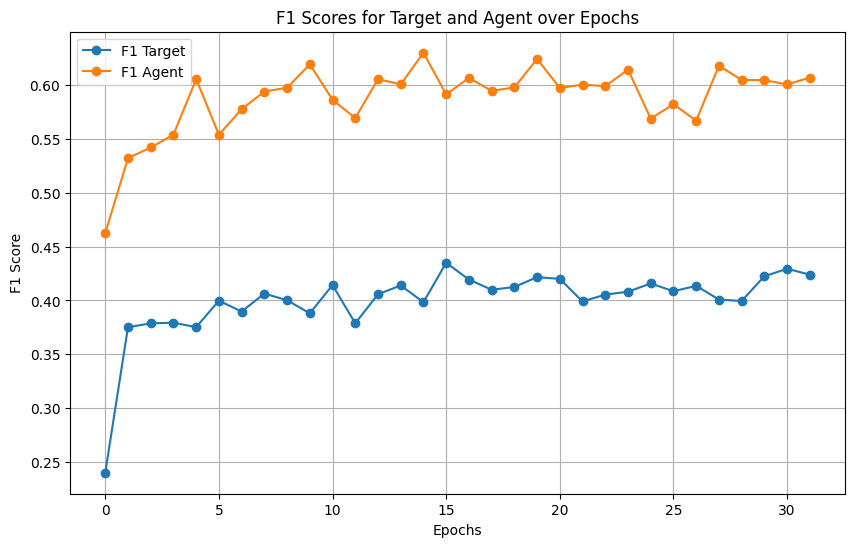

In [27]:
import matplotlib.pyplot as plt
# Plot F1 scores for target and agent
epochs = range(0, EPOCH)

plt.figure(figsize=(10, 6))
plt.plot(epochs, f1_scores_target, label='F1 Target', marker='o')
plt.plot(epochs, f1_scores_agent, label='F1 Agent', marker='o')

plt.xlabel('Epochs')
plt.ylabel('F1 Score')
plt.title('F1 Scores for Target and Agent over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [28]:
target_accuracy = evaluate_model(model, val_data_loader, 'target')
agent_accuracy = evaluate_model(model, val_data_loader, 'agent')
print(f'f1 Agent: {agent_accuracy}. f1 Target: {target_accuracy}\n\n----------------------')

matched: 609, predicted_len: 1488, actual_len: 1385
matched: 910, predicted_len: 1586, actual_len: 1413
f1 Agent: 0.6068689563187729. f1 Target: 0.4239470936303516

----------------------


In [29]:
## fold0:
# agent0 = 
# target0 =

## fold1:
# agent1 = 
# target1 =

## fold2:
# agent2 =
# target2 =

## fold3:
# agent3 = 
# target3 =

## fold4:
# agent4 =
# target =